# <center><span style='background:yellow'>Améliorez le produit IA de votre start-up (partie 3)</span></center>
# <center><span style='background:yellow'>Analyse de texte</span></center>
=========================================================================================================================

### Table of Contents <a class="anchor" id="sommaire"></a>

* [Import des librairies et recupération des avis négatifs](#1)
    * [Import des librairies et chargement des données](#11)
    * [Sélection des avis négatifs](#12)
* [Nettoyage du corpus](#2)
    * [Fonction de nettoyage](#21)
    * [Visualisation](#22)

* [Bag of words](#3)
    * [Premier nettoyage](#31)  
        * [Calcul de score de cohérence](#311)   
        * [Visualisation du premier modèle avec 4 topics](#312) 
        * [Visualisation du premier modèle avec 2 topics](#312)
    * [Nettoyage supplémentaire](#33)   
        * [Calcul de score de cohérence](#321)   
        * [Visualisation du modèle final avec 2 topics](#323) 

# Import des librairies et sélection des avis négatifs<a class="anchor" id="1"></a>

## Import des librairies et chargement des données<a class="anchor" id="11"></a>

In [1]:
import pandas as pd

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

#visualisations de corpus
from wordcloud import WordCloud

#netoyage de texte
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import words, stopwords
from nltk.tokenize import RegexpTokenizer

#bag of words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#visualisation de LDA
import pyLDAvis
from pyLDAvis import gensim_models
from gensim import models
from gensim.corpora.dictionary import Dictionary
pyLDAvis.enable_notebook()

#Avancement des calculs
from tqdm import tqdm

#calcul en parallele
from pandarallel import pandarallel


#Downloads
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
nltk.download('omw-1.4')

C:\Users\modes\anaconda3\envs\OpenClassrooms_projet6\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
C:\Users\modes\anaconda3\envs\OpenClassrooms_projet6\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\modes\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\modes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\modes\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_da

True

In [2]:
pandarallel.initialize(progress_bar=True, 
                       nb_workers=4, 
                       verbose=2)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [3]:
#Récuperation du fichier des avis enregistré dans la mémoire
%store -r bad_reviews

<a href="#sommaire" rev="footnote">&#8617;</a>

## Sélection des avis négatifs<a class="anchor" id="12"></a>

On choisit les avis avec un score de 1 et un nombre de mots inférieur à 15.

In [4]:
print(f'On se dispose de {bad_reviews.shape[0]} avis négatifs' )

On se dispose de 6176 avis négatifs


In [5]:
pd.options.display.max_colwidth = 100
bad_reviews_text = bad_reviews.text
display(bad_reviews_text.head())
pd.reset_option('display.max_colwidth')

359                                            They served me a frozen pizza and skunked beer.  'Nuff said.
2839    Drove past this place recently and I think it's closed .,..........................................
5019                               no bueno...annoyed I couldn't get any service and the prices are a joke.
6236                                                     Breakfast was vile, everything tasted like grease!
7249                Mini size boong-uh-bbang for $2???\nPhoto looks like regular size. \nFalse advertising.
Name: text, dtype: object

<a href="#sommaire" rev="footnote">&#8617;</a>

# Nettoyage du corpus<a class="anchor" id="2"></a>

## Fonction de nettoyage<a class="anchor" id="21"></a>

Diffétentes étapes de nettoyage : 
* **Passer tous mots en minuscules**
* **Tokeniser**
* **Enlever les stop words**
* **Enlever les tokens de longueur inférieurs strictement à 3**
* **Garder que les tokens alphaphétiques**
* **Lemmatiser**
* **Garder que les mots en anglais**

In [6]:
#Text cleaning
def first_text_cleaning(doc, 
                   rejoin=False,
                   lem_or_stemm="lem",
                   list_rare_words=None,
                   min_len_words=3,
                   force_in_alpha=True,
                   eng_word=words.words()):
    
    """
    
    """
    import nltk
    from nltk.stem import WordNetLemmatizer, PorterStemmer
    from nltk.tokenize import word_tokenize, wordpunct_tokenize
    from nltk.corpus import words, stopwords
    from nltk.tokenize import RegexpTokenizer
    
    #rare words
    if not list_rare_words :
        list_rare_words = []
        
    #lower
    doc = doc.lower()
    
    #tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(doc)
    
    #stopwords
    stop_words = stopwords.words('english')
    cleaned_tokens = [w for w in tokens if w not in stop_words]
    
    #No more len char
    no_more_len_char = [w for w in cleaned_tokens if len(w) >= min_len_words]
    
    #Garder que les alphabetiques
    if force_in_alpha :
        tokens_alpha = [w for w in no_more_len_char if w.isalpha()]
    else : 
        tokens_alpha = no_more_len_char
            
    #stem or lem 
    if not lem_or_stemm: 
        trans_text = no_more_len_char
        
    elif lem_or_stemm == "lem":
        trans = WordNetLemmatizer()
        trans_text = [trans.lemmatize(w) for w in tokens_alpha]
        
    elif lem_or_stemm == "stem":
        trans = PorterStemmer()
        trans_text = [trans.stem(w) for w in tokens_alpha]
        
    #only english word
    if eng_word:
        eng_word_tokens = [w for w in trans_text if w in eng_word]
    else:
        eng_word_tokens = trans_text
        
    #return token type
    if rejoin :
        return ' '.join(eng_word_tokens)
    else: 
        return eng_word_tokens

In [7]:
#Display tokens infos
def display_token_info(doc):
    """token infos
    """    
    print('Nombre total de tokens', len(doc),', nombre unique de tokens', len(set(doc)))

In [8]:
#Création du corpus
corpus_ = ' '.join(bad_reviews_text.values)
corpus_cleaned = first_text_cleaning(corpus_, rejoin=False, lem_or_stemm='lem', eng_word=words.words())

#Test function display_token_info
display_token_info(corpus_cleaned)

Nombre total de tokens 41162 , nombre unique de tokens 4550


<a href="#sommaire" rev="footnote">&#8617;</a>

## Visualisation<a class="anchor" id="22"></a>

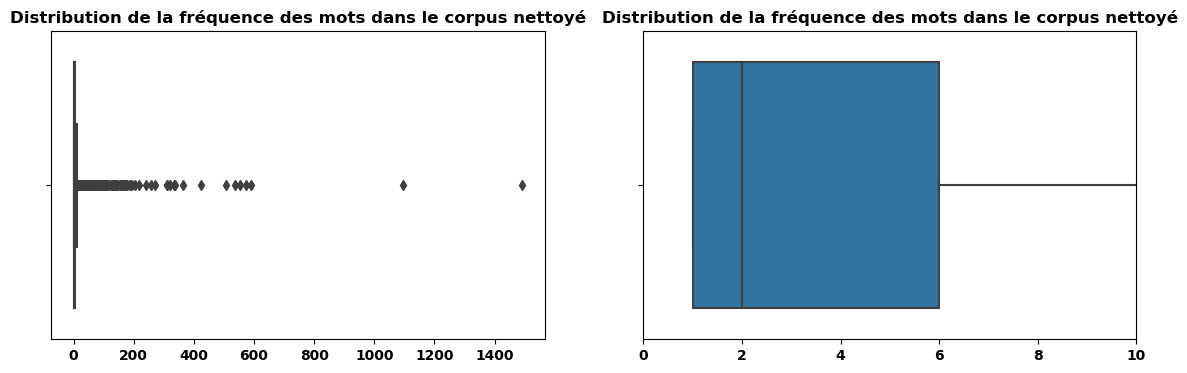

In [9]:
tmp = pd.Series(corpus_cleaned).value_counts()

#visualisation de la distribution des fréquences des mots
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.boxplot(x = tmp)
plt.title('Distribution de la fréquence des mots dans le corpus nettoyé')

plt.subplot(122)
sns.boxplot(x = tmp)
plt.xlim(0,10)
plt.title('Distribution de la fréquence des mots dans le corpus nettoyé')
plt.show()

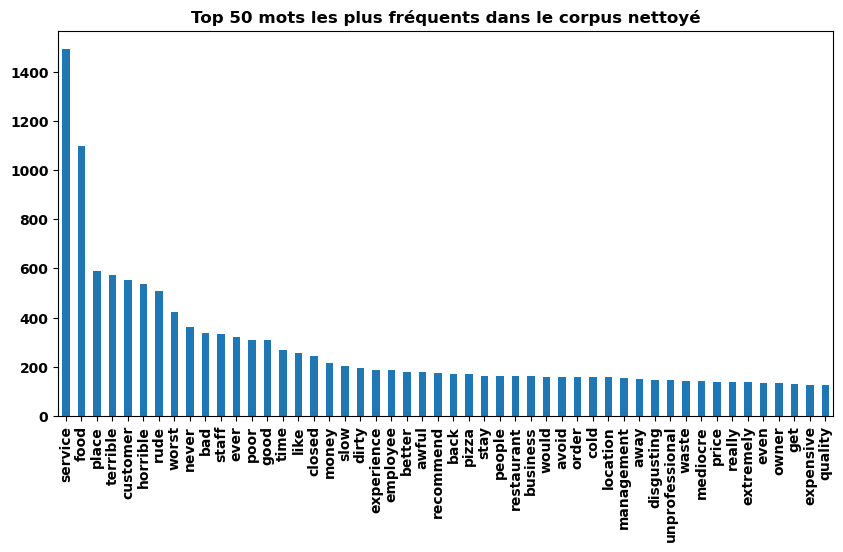

In [10]:
plt.figure(figsize=(10,5))
tmp[:50].plot.bar()
plt.title('Top 50 mots les plus fréquents dans le corpus nettoyé')
plt.show()

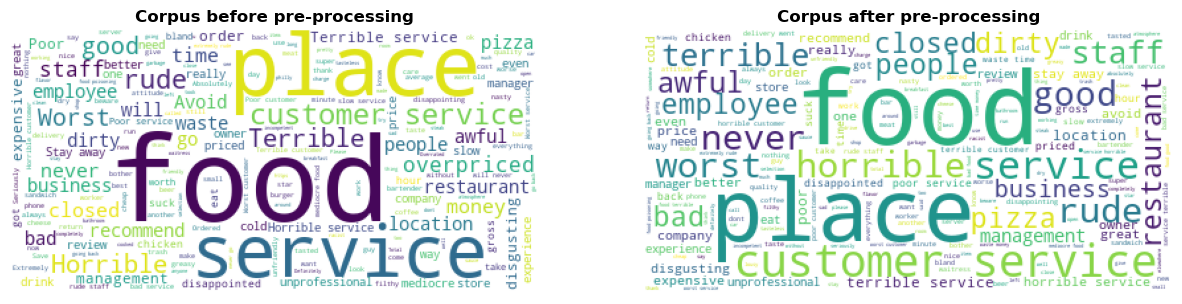

In [11]:
import warnings
warnings.filterwarnings('ignore')
    
fig = plt.figure(figsize=(15,5))

plt.subplot(121)
word_cloud = WordCloud(background_color='white').generate(corpus_)
plt.imshow(word_cloud)
plt.axis('off')
plt.title('Corpus before pre-processing')

plt.subplot(122)
word_cloud = WordCloud(background_color='white').generate(" ".join(corpus_cleaned))
plt.imshow(word_cloud)
plt.axis('off')
plt.title('Corpus after pre-processing')
plt.show()

fig.savefig('cleantext.png')

<a href="#sommaire" rev="footnote">&#8617;</a>

# Bag of words<a class="anchor" id="3"></a>

## Premier nettoyage<a class="anchor" id="31"></a>

In [12]:
#Appliquer le cleaning sur chaque revue du corpus
bad_reviews['text_cleaned_tokens'] = bad_reviews.text.parallel_apply(first_text_cleaning)
bad_reviews['text_cleaned'] = bad_reviews['text_cleaned_tokens'].apply(lambda x : ' '.join(x))

In [13]:
bad_reviews[['review_id', 'text','text_cleaned']].head(10)

,review_id,text,text_cleaned
359,y1CYqccQLsn8GGXYS4q6tQ,They served me a frozen pizza and skunked beer...,frozen pizza beer said
2839,qEHARyQd3bjfwr9mxwCO5A,Drove past this place recently and I think it'...,drove past place recently think closed
5019,_hxVKINfqPKb_1H5krTgrQ,no bueno...annoyed I couldn't get any service ...,get service price joke
6236,Kpmo7iNyr9ucOQbjI21gew,"Breakfast was vile, everything tasted like gre...",breakfast vile everything tasted like grease
7249,wyuWpps_e5UzbfpOLr6baQ,Mini size boong-uh-bbang for $2???\nPhoto look...,size photo look like regular size false advert...
7361,GRk5hNq0po_FfpN-HV4EAg,"Did not care for the food, service was mediocr...",care food service mediocre parking dismal
7668,Hh4L63rODXJFHXmAYdFIRg,Biggest group of Dunkin Donuts idiots I have e...,biggest group idiot ever come across life
7868,gMBKx_Lj1ZhW6zvXgVRhKg,Absolutely disgusting. Do yourself a favor and...,absolutely disgusting favor never order food t...
8579,oPJGfvT67spMTtWVwzRaXw,Good service but TERRIBLE FOOD. Overcooked eve...,good service terrible food everything one wors...
9051,scbVrbp_ZAdai96IwPocLQ,"Terrible selection, even worse quality. Big mi...",terrible selection even worse quality big mist...


In [14]:
bad_reviews.shape

(6176, 11)

<a href="#sommaire" rev="footnote">&#8617;</a>

###  Calcul de score de cohérence<a class="anchor" id="311"></a>

Le score de cohérence **Umass** mésure la fréquence à laquelle deux mots apparaissent ensemble

In [15]:
def compute_coherence_values(data, topic_values, seed=None):

    #Dictionnaire du mot et son identifiant
    dictionnary = Dictionary(data)  

    #vectorisation
    corpus = [dictionnary.doc2bow(tokens) for tokens in data]

    #List des scores de coherences
    coherence_values = []
    
    #List des modèles
    model_list = []

    for num_topic in tqdm(topic_values):
        
        model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionnary, num_topics=num_topic, random_state=seed)
        model_list.append(model)
        coherence_model = models.CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        coherence_values.append(coherence_model.get_coherence())
        
    return coherence_values, model_list

In [16]:
def graph_cohenrence_score(coherence_values, list_n_topic=range(2,11), save=None):
    
    data = pd.DataFrame({'n_topics':list_n_topic, 'coherence_value': coherence_values})
    
    fig = plt.figure(figsize=(10,4))
    sns.set_style('whitegrid')
    sns.pointplot(data=data, x='n_topics', y='coherence_value')
    plt.xlabel('Nombre de topics')
    plt.ylabel('Score de cohérence')
    plt.title('Le score de cohérence u_mass selon le nombre de topics')
    plt.show()
    if save :
        fig.savefig(save)

In [17]:
# Calcul le coherence score pour plusieurs valeurs de l'hyperparamètres num_topic
seed = 1
dataset = bad_reviews.text_cleaned_tokens.to_list()
topic_values = range(2,11)
coherence_values = compute_coherence_values(dataset, topic_values=topic_values, seed=seed)[0]

100%|██████████| 9/9 [00:33<00:00,  3.71s/it]


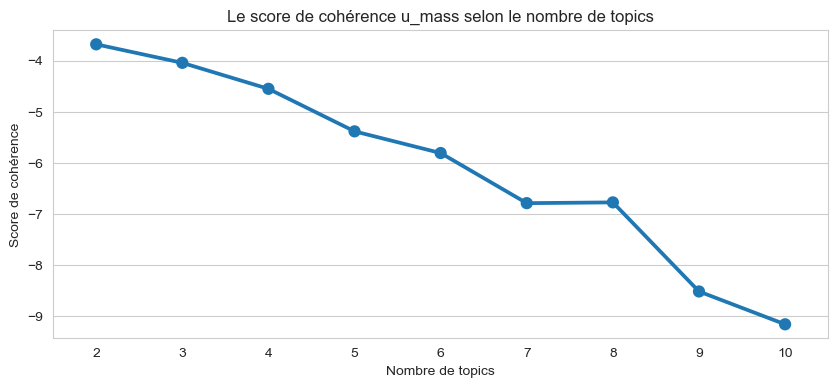

In [18]:
graph_cohenrence_score(coherence_values, save='coh_score1.png')

<a href="#sommaire" rev="footnote">&#8617;</a>

###  Visualisation du premier modèle  avec 4 topics<a class="anchor" id="312"></a>

In [19]:
n_top = 4
print(f"Le score de cohérence associé à 4 topics est égale {round(coherence_values[topic_values.index(n_top)],2)}.")

Le score de cohérence associé à 4 topics est égale -4.55.


In [20]:
def display_topics_graph(model, no_top_words=50, save=None):
    
    n_top = model.get_topics().shape[0]

    if n_top % 2 == 0:
        figure_len = 2.
        len1 = n_top//2
            
    else :
        figure_len = 2.5
        len1 = n_top//2 + 1
        
    fig = plt.figure(figsize=(15,figure_len*n_top))
    
    for topic_idx in range(n_top):
        plt.subplot(len1,2,(topic_idx+1))
        word_cloud = WordCloud(background_color='white').fit_words(dict(model.show_topic(topicid=topic_idx, topn=no_top_words)))
        plt.imshow(word_cloud)
        plt.axis('off')
        plt.title(f'Topic {topic_idx+1}', fontdict={'family':'serif','color':'black','size':20})
    plt.show()
    
    if save:
        fig.savefig(save)

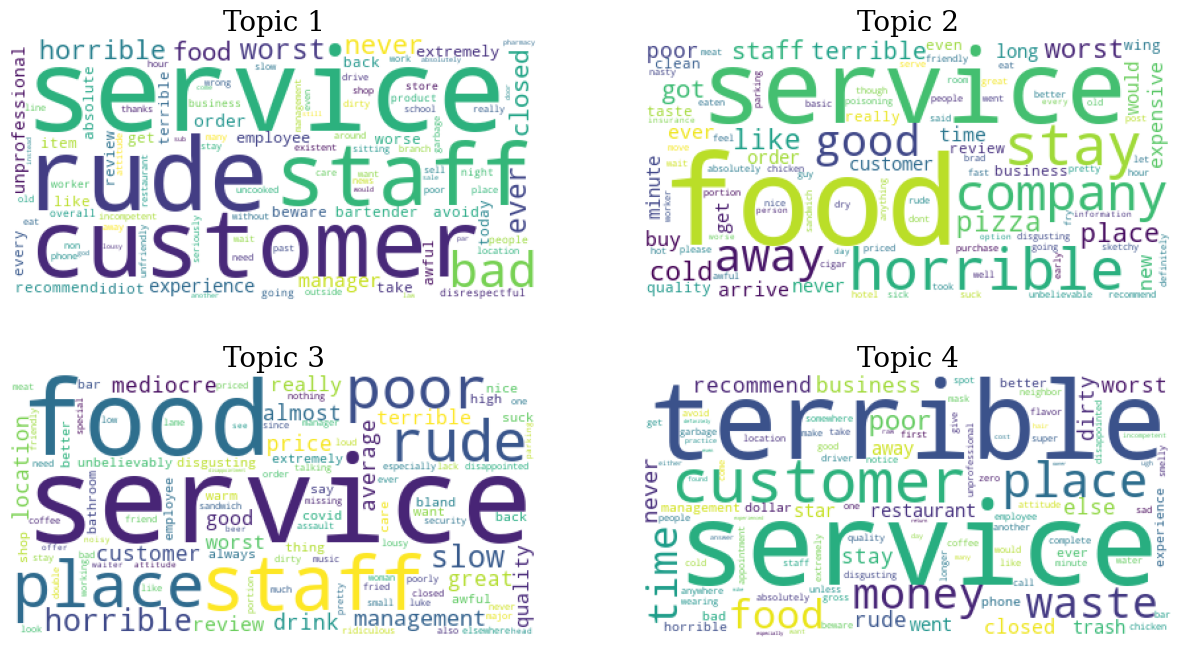

In [21]:
dictionnary = Dictionary(dataset)
corpus = [dictionnary.doc2bow(tokens) for tokens in dataset]
lda = models.ldamodel.LdaModel(corpus = corpus, 
                               id2word = dictionnary, 
                               num_topics = n_top, 
                               random_state = seed)   
display_topics_graph(lda,100, save='wordcould11.png')

In [22]:
gensim_models.prepare(lda, corpus, dictionnary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.118811 -0.030791       1        1  26.512380
3      0.060954  0.102418       2        1  25.696516
2     -0.045375 -0.137174       3        1  23.945734
1     -0.134390  0.065546       4        1  23.845370, topic_info=         Term        Freq       Total Category  logprob  loglift
189     waste  178.000000  178.000000  Default  30.0000  30.0000
43   terrible  514.000000  514.000000  Default  29.0000  29.0000
209     money  201.000000  201.000000  Default  28.0000  28.0000
188      time  209.000000  209.000000  Default  27.0000  27.0000
860   company  145.000000  145.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
10        get   41.664599  136.516689   Topic4  -5.4620   0.2468
63   business   40.662693  162.250466   Topic4  -5.4864   0.0497
221    really   40.024696  136.402797   Topic4  -5.5022   0.2075
130  customer   43.177487  524.197140   Topic4  -5.4264  -1.0630
41      never   41.394405  295.482222   Topic4  -5.4685  -0.5319

[323 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3367      3  0.936415  abrasive
1013      1  0.910588  absolute
1013      2  0.088838  absolute
1600      3  0.960845     abuse
2443      2  0.971586   account
...     ...       ...       ...
385       3  0.109188     would
385       4  0.344364     would
120       2  0.815435      zero
120       3  0.027181      zero
120       4  0.163087      zero

[582 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

###  Visualisation du premier modèle  avec 2 topics<a class="anchor" id="313"></a>

In [23]:
n_top = 2
print(f"Le score de cohérence associé à 2 topics est égale {round(coherence_values[topic_values.index(n_top)],2)}.")

Le score de cohérence associé à 2 topics est égale -3.68.


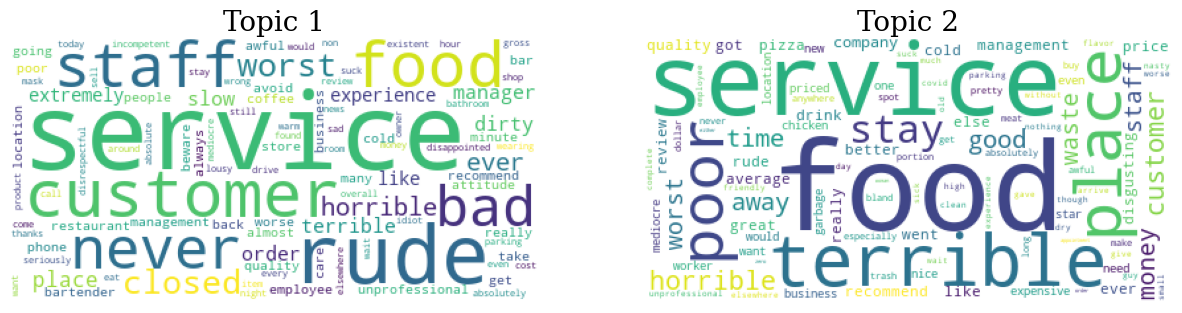

In [24]:
dictionnary = Dictionary(dataset)
corpus = [dictionnary.doc2bow(tokens) for tokens in dataset]
lda = models.ldamodel.LdaModel(corpus = corpus, 
                               id2word = dictionnary, 
                               num_topics = n_top, 
                               random_state = seed)   
display_topics_graph(lda,100, save='wordcould12.png')

Le MDS s'intéresse à la structure globale des points et essaie de conserver les distance entre les points dans l'espace de dimension inférieure

In [25]:
gensim_models.prepare(lda, corpus, dictionnary)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.079013  0.0       1        1  50.341549
1     -0.079013  0.0       2        1  49.658451, topic_info=        Term        Freq       Total Category  logprob  loglift
4     closed  240.000000  240.000000  Default  30.0000  30.0000
57       bad  259.000000  259.000000  Default  29.0000  29.0000
41     never  301.000000  301.000000  Default  28.0000  28.0000
170     away  214.000000  214.000000  Default  27.0000  27.0000
188     time  210.000000  210.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
17      like   96.817207  220.603205   Topic2  -5.3524  -0.1235
134     rude  114.969563  473.570653   Topic2  -5.1806  -0.7156
243   review   75.953960  131.031140   Topic2  -5.5951   0.1547
52   quality   74.885149  134.525422   Topic2  -5.6093   0.1142
34      ever   75.120332  295.254286   Topic2  -5.6062  -0.6687

[178 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1600      1  0.059368         abuse
1600      2  0.949894         abuse
4302      1  0.056661  accidentally
4302      2  0.963238  accidentally
674       1  0.053121       address
...     ...       ...           ...
398       2  0.698614          went
48        1  0.584351         worst
48        2  0.414025         worst
120       1  0.053807          zero
120       2  0.941630          zero

[271 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

**Sujet 1** : Critique essentiellement le service, la nouriture  
**Sujet 2** : Critique également le service et la nouriture  

<a href="#sommaire" rev="footnote">&#8617;</a>

##  Nettoyage supplémentaire<a class="anchor" id="32"></a>

Nettoyage supplémentaire:
* **Garder que les noms**
* **Supprimer les mots uniques**

In [26]:
def keep_noun(tokens):
    pos_tag = nltk.pos_tag(tokens)
    nouns = []
    for noun, cat in pos_tag:
        if cat == 'NN' :
            nouns.append(noun)
    return nouns

def final_text_cleaning(corpus): 
            
    #Garder que les noms
    corpus_cleaned = []
    for tokens in corpus:
        token_cleaned = keep_noun(tokens)
        corpus_cleaned.append(token_cleaned)
    
    #Supprimer les mots uniques
    frequency = defaultdict(int)
    for tokens in corpus_cleaned:
        for token in tokens:
            frequency[token] += 1
        texts = [[token for token in tokens if frequency[token] > 1] for tokens in corpus_cleaned]
    
    return texts

In [27]:
dataset_2 = final_text_cleaning(dataset)

bad_reviews['text_cleaned_tokens_2'] = dataset_2
bad_reviews['text_cleaned_2'] = bad_reviews['text_cleaned_tokens_2'].apply(lambda x: ' '.join(x))
bad_reviews[['text','text_cleaned','text_cleaned_2']].head()

,text,text_cleaned,text_cleaned_2
359,They served me a frozen pizza and skunked beer...,frozen pizza beer said,pizza beer
2839,Drove past this place recently and I think it'...,drove past place recently think closed,place
5019,no bueno...annoyed I couldn't get any service ...,get service price joke,service price joke
6236,"Breakfast was vile, everything tasted like gre...",breakfast vile everything tasted like grease,breakfast everything grease
7249,Mini size boong-uh-bbang for $2???\nPhoto look...,size photo look like regular size false advert...,size photo size advertising


<a href="#sommaire" rev="footnote">&#8617;</a>

###  Calcul de score de cohérence<a class="anchor" id="321"></a>

In [28]:
# Calcul le coherence score pour plusieurs valeurs de l'hyperparamètres num_topic
seed = 1
dataset_2 = bad_reviews.text_cleaned_tokens_2.to_list()
list_n_topics_2 = range(2,11)
coherence_values_2 = compute_coherence_values(data=dataset_2, topic_values=list_n_topics_2, seed=seed)[0]

100%|██████████| 9/9 [00:26<00:00,  2.91s/it]


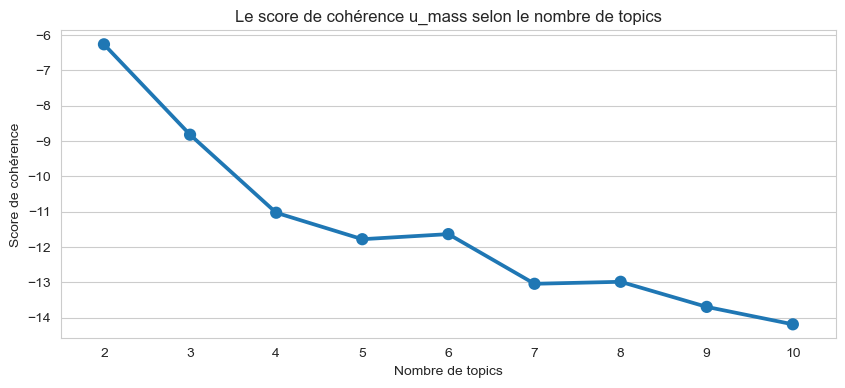

In [29]:
graph_cohenrence_score(coherence_values_2, save='coh_score2.png')

<a href="#sommaire" rev="footnote">&#8617;</a>

###  Visualisation du modèle final  avec 2 topics<a class="anchor" id="323"></a>

In [30]:
n_top = 2
print(f"Le score de cohérence associé à 2 topics est égale {round(coherence_values_2[list_n_topics_2.index(n_top)],2)}.")

Le score de cohérence associé à 2 topics est égale -6.26.


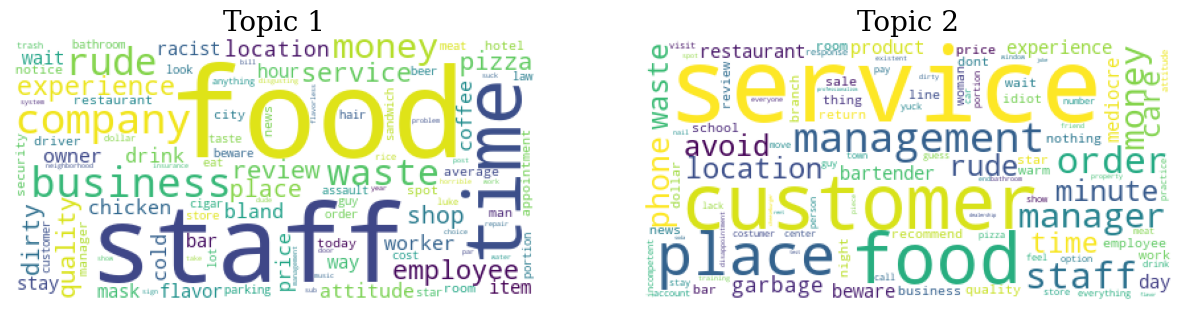

In [31]:
dictionnary_2 = Dictionary(dataset_2)
corpus_2 = [dictionnary_2.doc2bow(tokens) for tokens in dataset_2]

lda_2 = models.ldamodel.LdaModel(corpus = corpus_2, 
                               id2word = dictionnary_2, 
                               num_topics = n_top, 
                               random_state = seed)  

display_topics_graph(lda_2,100, 'wordcloud22.png')

**Sujet 1** : Critique essentiellemnt la nouriture, le personnel et le temps (probablement le temps d'attente)  
**Sujet 2** : Critique le service, la nouriture, le management 

In [32]:
gensim_models.prepare(lda_2, corpus_2, dictionnary_2)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.104031  0.0       1        1  52.311058
0     -0.104031  0.0       2        1  47.688942, topic_info=           Term         Freq        Total Category  logprob  loglift
5       service  1250.000000  1250.000000  Default  30.0000  30.0000
56     customer   549.000000   549.000000  Default  29.0000  29.0000
2         place   479.000000   479.000000  Default  28.0000  28.0000
415     company   147.000000   147.000000  Default  27.0000  27.0000
116  management   200.000000   200.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
103        hour    44.896730    62.370463   Topic2  -5.3291   0.4117
40          way    44.385837    63.109362   Topic2  -5.3406   0.3885
5       service    98.733861  1250.377095   Topic2  -4.5411  -1.7983
2         place    69.772952   479.869689   Topic2  -4.8882  -1.1878
174        wait    46.143252    75.804465   Topic2  -5.3017   0.2441

[161 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1108      1  0.983990    account
1108      2  0.044727    account
333       1  0.051193    address
333       2  0.972670    address
676       1  0.051117  advantage
...     ...       ...        ...
85        2  0.575583      waste
40        1  0.301065        way
40        2  0.697202        way
560       1  0.177448     worker
560       2  0.818992     worker

[238 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

<a href="#sommaire" rev="footnote">&#8617;</a>